In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 60

In [3]:
#utils.py is where all our custorm functions live is we set an autoreload on it.
%aimport utils 
from utils import *

# The data

In [4]:
df_all = pd.read_excel('all data v3.xlsx', 'iLab data.txt', index_col=None, na_values=['NA'])

### Preparing a test sample
Let's first use a particular session as a test case. We extract only the data relevant to that case

In [5]:
df_test = prepare_session(df_all,'L-2567b17a:120eda25685:-8000')
df_gaps = prepare_session(df_all,'L-10f11766:120ecd4f63a:-8000')

After removin 'incorrect' actions, we are left with 212 rows out of 285
After removin 'incorrect' actions, we are left with 207 rows out of 288


In [6]:
# #Using the example used for sketch.
# def export_df(df,name):
#     select_df = df[["Session Id","Selection","Feedback Text","Cleaned method 1","Cleaned method 2","cases","Time_seconds","Timeshifted","Duration"]]
#     writer = pd.ExcelWriter(name+'.xlsx')
#     select_df.to_excel(writer,'Sheet1')
#     writer.save()

# export_df(df_gaps,'gaps')
# export_df(df_test,'test')

# The plot

In [13]:
colors = {"Cases":"white",
         "Now try working on this new example":"#252525",
         "intuition": "#969696",
         "Single value": "red",
         'Central tendency': "#33a02c",
         'Other distance': "#6a3d9a",
#          'Average': "#6a3d9a",
#          'Sum': "#1f78b4",
          'Count gaps': "red",
          'Range': "#1f78b4",
         'Count all': "#ff7f00",
         'Other': "#ff7f00", 
         'evaluation steps': "#525252",
          'submit': "#525252",
          "Build":'black',
          "deleteAll":'black',
        }
column_to_use = {"Now try working on this new example":"Feedback Text",
                 "intuition": "Selection",
                 "submit": "Selection",
                 "evaluation": "Selection",
                 "checkIntuition": "Selection",
                 "deleteAll":"Selection",
                }

function_to_use = {"Cases":case_usage,
                   "Single value":single_value_usage,
                   "Central tendency":central_tendency_usage,
                   "Range":range_usage,
                   "Other distance":distance_usage,
                   "Count gaps":count_gaps_usage,
                   "Build": build_events,
                   "evaluation steps":evaluation_steps_usage,
                   'Count all': count_all_usage,
                   "Other":other_usage}

to_plot = ["Cases","intuition",'Single value','Central tendency',"Count all","Count gaps",'Range',"Other distance","Other","Build","deleteAll","submit","evaluation steps"]

In [29]:
def plot(df,to_plot,colors, column_to_use, function_to_use):
    fig = plt.figure(figsize=(18,9))
    ax = plt.subplot()
    spacing =10
    pos = 0
    max_time = 0
    actions = list(reversed(to_plot))
    black = '#252525'
    for i,action in enumerate(actions):
        if action == "Cases":
            cases = all_cases(df)
            for case,coords in all_cases(df).items():
                left = [float(x) for x in case[0].split(" ")]
                right = [float(x) for x in case[1].split(" ")]
                ymax = max(max(left),max(right))
                ymin = min(min(left),min(right))
                Xl = [coords[0]+30]*len(left)
                Yl = [l/(ymax)*(spacing-2.5)+1+pos for l in left]
                Xr = [coords[0]+30+20]*len(right)
                Yr = [r/(ymax)*(spacing-2.5)+1+pos for r in right]
                ax.plot(Xl,Yl,'.',color="darkgrey",markersize=10)
                ax.plot(Xr,Yr,'.',color="darkgrey",markersize=10)
                case_pos = pos
        if action in column_to_use.keys():
            action_use = action_usage(df,column_to_use[action],action)
        else:
            action_use = function_to_use[action](df)
        if action_use:
            max_time = max(max_time,sum(action_use[-1]))
            ax.broken_barh(action_use,(pos,spacing),facecolors=colors[action],alpha=1,linewidth=0)
        pos += spacing

    coords = zip(df[df['Feedback Text'].str.contains("Good. Click Done to continue.",na=False)]['Time_seconds'],df[df['Feedback Text'].str.contains("Good. Click Done to continue.",na=False)]['Duration'])
    solutions_left = df[df['Feedback Text'].str.contains("Good. Click Done to continue.",na=False)]['Cleaned method 1']
    solutions_right = df[df['Feedback Text'].str.contains("Good. Click Done to continue.",na=False)]['Cleaned method 2']
    solutions = [sl+' | '+sr for sl,sr in zip (solutions_left,solutions_right)]

    for s,coord in zip (solutions,coords):
        ax.text(coord[0]-5,case_pos+spacing/2,s,horizontalalignment='right',fontsize=14)

#     #Add horizontal bar
#     ax.broken_barh([(0,ax.get_xlim()[1])],((len(actions))*spacing,spacing),facecolors='white',alpha=1,linewidth=0)

    #Add new case bar
    new_case = "Now try working on this new example"
    action_use = action_usage(df,column_to_use[new_case],new_case)
    case_use = [(x-10,10) for (x,y) in action_use]+[(-10,10)]
    max_time = max(max_time,sum(action_use[-1]))
    ax.broken_barh(case_use,(0,(len(actions))*spacing),facecolors="white",alpha=1,linewidth=0)

    #Add labels
    ax.set_xlabel('minutes in activity',fontsize=13)
    ax.set_xticks(range(0,int(max_time),60))
    ax.set_xticklabels([str(x/60)+''if x in range(0,int(max_time),60*5) else "" for x in range(0,int(max_time),60)],fontsize=13)
    ax.set_yticks(range(spacing/2,len(actions)*spacing,spacing))
    ax.set_yticklabels([a.capitalize() for a in actions],fontsize=15)
    ax.grid(True)
    plt.show()

### Session with gap counting

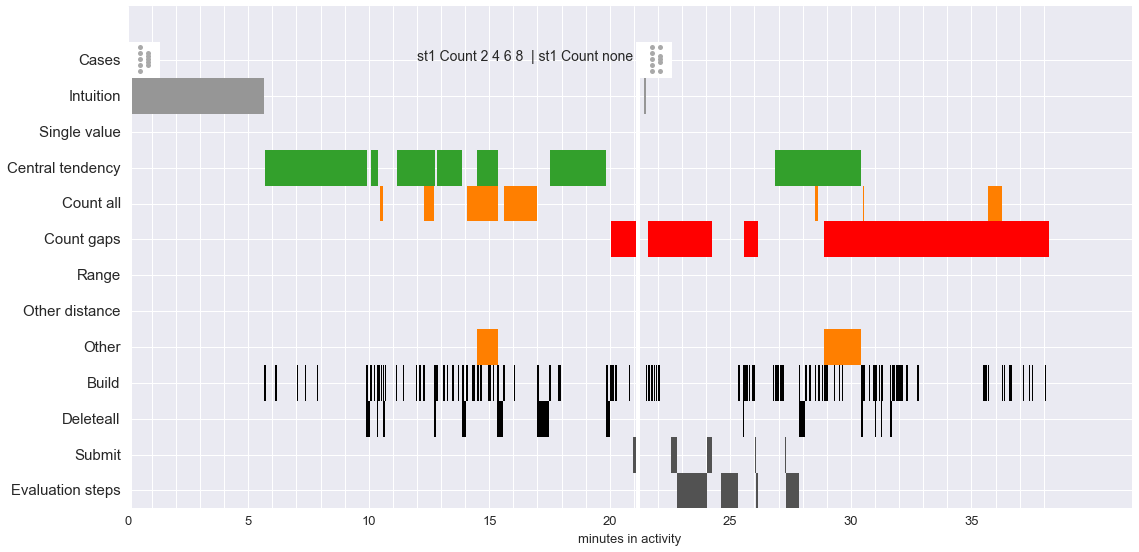

In [23]:
plot(df_gaps,to_plot,colors, column_to_use, function_to_use)

### Session with range and extrapolated range

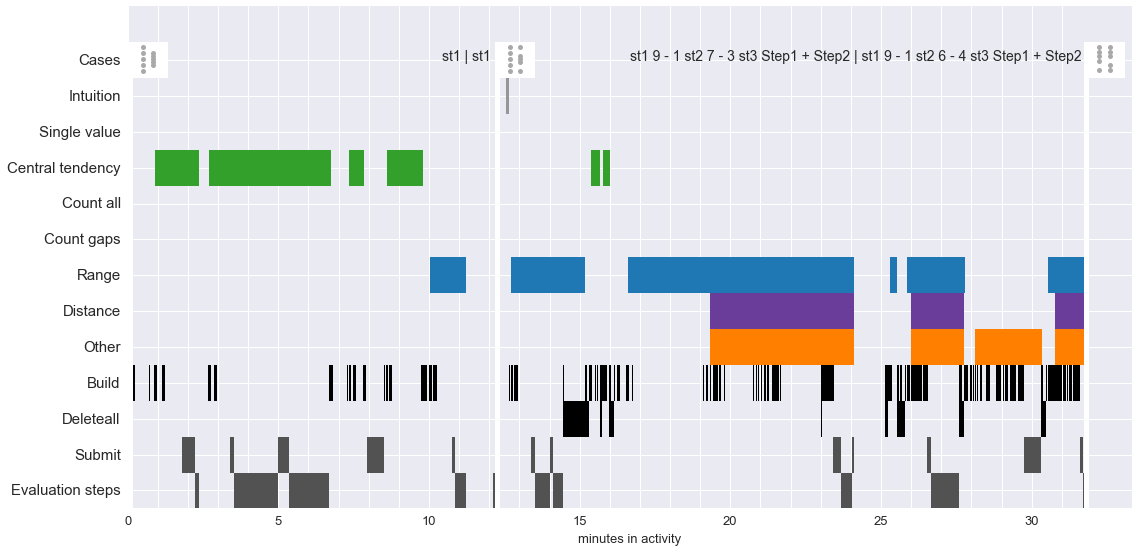

In [10]:
plot(df_test,to_plot,colors, column_to_use, function_to_use)

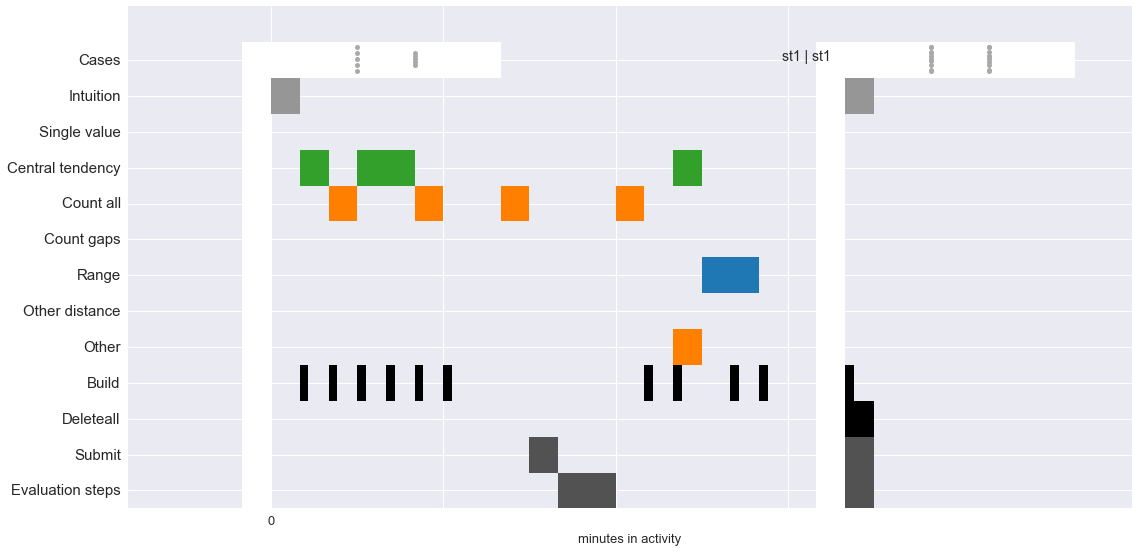

In [67]:
df_test2 = pd.read_excel('all_method_tester.xlsx', 'Sheet1', index_col=None, na_values=['NA'])

%autoreload
REGEX_SINGLE_VALUE_FIRST = "st\d \d(?:$|(?:\sst)|(?:\s[\-\+x/]\s[A-Z]))"
REGEX_SINGLE_VALUE_SECOND = "st\d [A-Z][\sa-z]+ [\-\+x/] \d(?:$|(?:\s?st))"

def single_value_usage(df):
    usage= []
    method1 = action_usage(df,'Cleaned method 1',REGEX_SINGLE_VALUE_FIRST)
    usage.extend(action_usage(df,'Cleaned method 2',REGEX_SINGLE_VALUE_FIRST))
    usage.extend(action_usage(df,'Cleaned method 1',REGEX_SINGLE_VALUE_SECOND))
    usage.extend(action_usage(df,'Cleaned method 2',REGEX_SINGLE_VALUE_SECOND))
    return clean_coords(usage)

single_value_usage(df_test2)

plot(df_test2,to_plot,colors, column_to_use, function_to_use)

### TO DO
#### Ordered in some kind of general priority (in terms of need of feedback and desired feature)
1. add Other category
* fix visual component of build, delete and submit
* clean visual - embellish
* run on all 9 student pairs

#### What can invention be? (Rename as Other)  - Two options:
1. Lots of differernt pre-set possibilities 
    * Anytime they use addition within a step?
    * Anytime they use multiplication
    * Use a combination of central tendency
    * Use a combination of methods (range and mean)
2. Any method that isn't other methods
    * after removing chuncks that fit our methods, is there anything left?
    * or
    * anything that has more than two steps subtracting time coords of methods.

#### Done
* central tendency (average median sum) - add "choose 2 4 5 7" in regex
* Show the method that eventually “cracks” the cases (succeeds to solve and move on)
